iter 0: loss=2.854120e+02, grad_norm=4.176e+01
iter 50: loss=2.139981e+02, grad_norm=7.833e-01
Gradient norm 4.206e-01 < tol -> stop at iter 60
Optimization time: 0.168 s, final loss=213.73


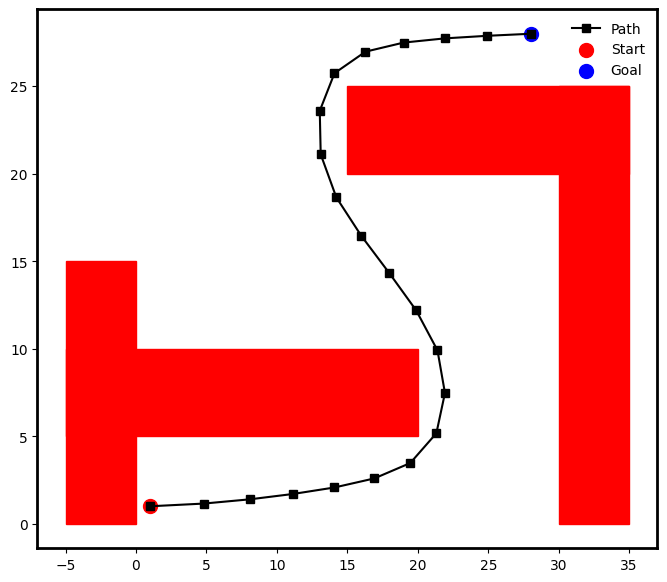

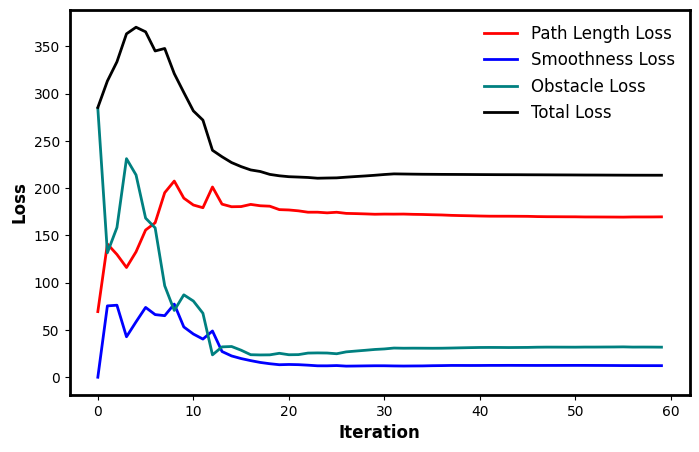

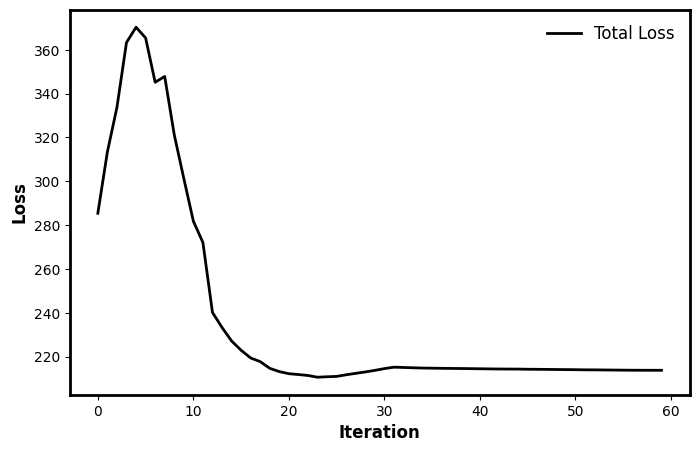

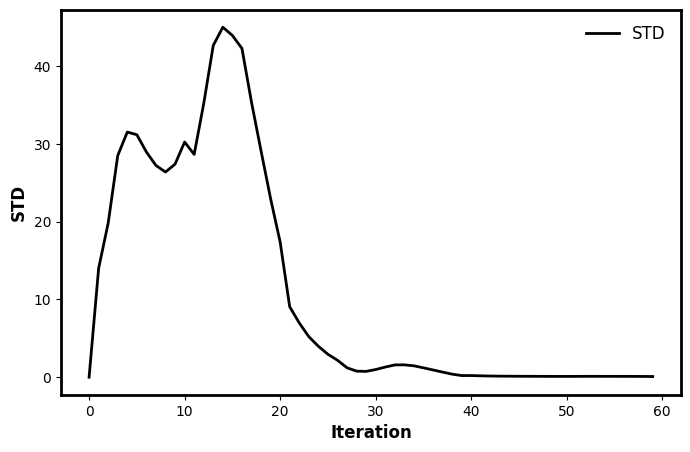

In [6]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import time
import os

from Functions.Plot_functions import Save_Frame, Plot_Optimized_Path, Plot_Optimized_All_History, Plot_Optimized_History
from Functions.Loss_functions import path_length_Loss, path_smoothness_Loss, path_obstacle_Loss
from Functions.Save_trj import Save_History2Csv, History_Save
from Functions.L_BFGS import LBFGS, line_search


frame_dir = "frames"
history_dir = "History_result"
history_name = datetime.now().strftime("%Y.%m.%d_%H.%M.%S").replace('.', '_') + "_history.csv"
os.makedirs(frame_dir, exist_ok=True)
os.makedirs(history_dir, exist_ok=True)

start = np.array([1.0, 1.0], dtype=np.float32)
goal = np.array([28.0, 28.0], dtype=np.float32)

#Basic
#obstacles = np.array([
#     [10,20,10,20,15,15]
#])


# Curve
obstacles = np.array([
    [-5, 20, 5, 10, 0, 7.5],
    [-5, 0, 0, 15, 0, 7.5],
    [15, 35, 20, 25,30,22.5],
    [30, 35, 0, 25,30,22.5]
], dtype=np.float32)

# Maze
#obstacles = np.array([
#     [15,25, 20, 25,20, 22.5],
#     [0,10,20,25, 5, 22.5],
#     [5,10,0,10,7.5,5],
#     [15,25,0,2,20,1],
#     [18,20,5,15,19,10]
#], dtype=np.float32)

N = 20  # control points
sample_pts = 4  # 기본 샘플링
margin = 2  # 장애물 여유
lambda_length = 1
lambda_smooth = 1
# 장애물 가중치 스케줄
lambda_obs = 0.1 # 초기값 증가
lambda_obs_max = 32
k_ramp = 1



# ==============================
# Optimization loop
points0 = np.linspace(start, goal, N+2)[1:-1].copy()
x = points0.flatten()
lbfgs = LBFGS(m=8)
max_iters = 200
tol = 1e-1
history = {"loss": [], "grad_norm": [], "L_length": [], "L_smooth": [], "L_obs": [], "STD": []}
start_time = time.time()
for k in range(max_iters):
    lambda_obs = min([lambda_obs + k_ramp, lambda_obs_max])
    def total_loss_and_grad_dynamic(x_in):
        inner = x_in.reshape(N,2)
        L1,g1 = path_length_Loss(start, goal, inner)
        L2,g2 = path_smoothness_Loss(start, goal, inner)
        L3,g3 = path_obstacle_Loss(start, goal, inner, obstacles, sample_pts_base=sample_pts, margin=margin)
        loss = lambda_length*L1 + lambda_smooth*L2 + lambda_obs*L3
        grad = lambda_length*g1 + lambda_smooth*g2 + lambda_obs*g3
        return loss, grad.flatten(), L1, L2, L3
    f,g,L1,L2,L3 = total_loss_and_grad_dynamic(x)
    grad_norm = np.linalg.norm(g)


    # terminate condition
    if k > 20 and np.std(history['loss'][-10:-1]) < tol:
        print(f"Gradient norm {grad_norm:.3e} < tol -> stop at iter {k}")
        break
    
    H_g = lbfgs.two_loop(g)
    p = -H_g

    alpha, f_new = line_search(x,f,g,p, lambda x_in: total_loss_and_grad_dynamic(x_in)[:2])
    x_new = x + alpha*p
    f_new, g_new, L1_new, L2_new, L3_new = total_loss_and_grad_dynamic(x_new)[:5]
    s = x_new - x
    y = g_new - g
    if np.dot(s,y) > 1e-10:
        lbfgs.update(s,y)
    x = x_new
    f = f_new
    g = g_new

    history = History_Save(history, f, grad_norm, lambda_length, lambda_smooth, lambda_obs, L1, L2, L3, k)

    #Save_Frame(x, N, start, goal, obstacles,k, frame_dir)

    if k % 50 == 0 or k == max_iters-1:
        print(f"iter {k}: loss={f:.6e}, grad_norm={grad_norm:.3e}")

opt_time = time.time() - start_time
print(f"Optimization time: {opt_time:.3f} s, final loss={f:.2f}")

# ============================== 
# plotting and saving results
Plot_Optimized_Path(x, N, start, goal, obstacles)
Plot_Optimized_All_History(history)
Plot_Optimized_History(history, 'loss', "Loss", "Total Loss")
Plot_Optimized_History(history, "STD", "STD", "STD")

#Save_History2Csv(history, history_dir, history_name)

**Update**

iter 0: loss=3.065429e+02, grad_norm=2.532e+01
Gradient norm 5.040e-01 < tol -> stop at iter 32
Optimization time: 0.105 s, final loss=293.87


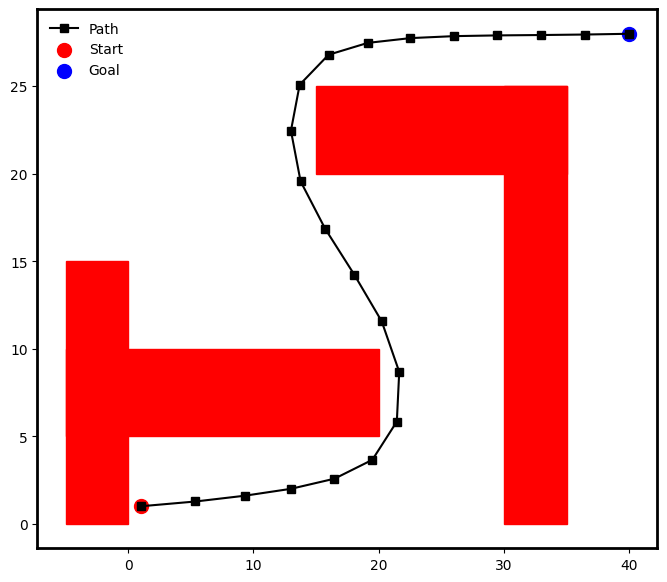

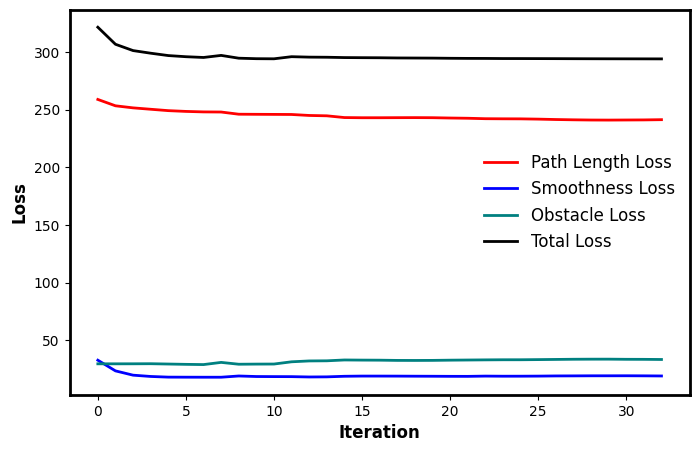

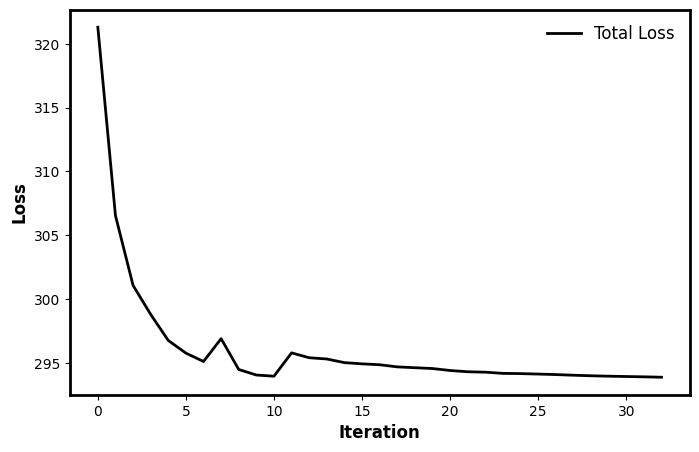

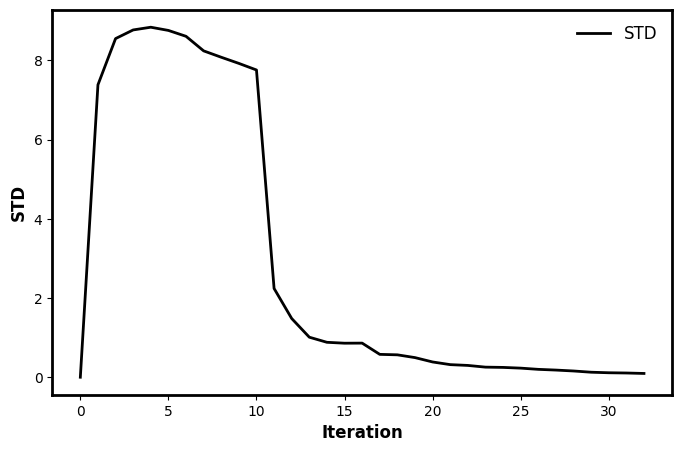

In [8]:

start = np.array([1.0, 1.0], dtype=np.float32)
goal = np.array([40.0, 28.0], dtype=np.float32)


# 이전의 최적화된 경로를 사용
points0 =  x.reshape(N, 2)
x = points0.flatten()
lbfgs = LBFGS(m=8)
history = {"loss": [], "grad_norm": [], "L_length": [], "L_smooth": [], "L_obs": [], "STD": []}
start_time = time.time()
for k in range(max_iters):
    lambda_obs = min([lambda_obs + k_ramp, lambda_obs_max])
    def total_loss_and_grad_dynamic(x_in):
        inner = x_in.reshape(N,2)
        L1,g1 = path_length_Loss(start, goal, inner)
        L2,g2 = path_smoothness_Loss(start, goal, inner)
        L3,g3 = path_obstacle_Loss(start, goal, inner, obstacles, sample_pts_base=sample_pts, margin=margin)
        loss = lambda_length*L1 + lambda_smooth*L2 + lambda_obs*L3
        grad = lambda_length*g1 + lambda_smooth*g2 + lambda_obs*g3
        return loss, grad.flatten(), L1, L2, L3
    f,g,L1,L2,L3 = total_loss_and_grad_dynamic(x)
    grad_norm = np.linalg.norm(g)
    
    history = History_Save(history, f, grad_norm, lambda_length, lambda_smooth, lambda_obs, L1, L2, L3, k)

    # terminate condition
    if k > 20 and np.std(history['loss'][-10:-1]) < tol:
        print(f"Gradient norm {grad_norm:.3e} < tol -> stop at iter {k}")
        break
    
    H_g = lbfgs.two_loop(g)
    p = -H_g

    alpha, f_new = line_search(x,f,g,p, lambda x_in: total_loss_and_grad_dynamic(x_in)[:2])
    x_new = x + alpha*p
    f_new, g_new, L1_new, L2_new, L3_new = total_loss_and_grad_dynamic(x_new)[:5]
    s = x_new - x
    y = g_new - g
    if np.dot(s,y) > 1e-10:
        lbfgs.update(s,y)
    x = x_new
    f = f_new
    g = g_new

    #Save_Frame(x, N, start, goal, obstacles,k, frame_dir)

    if k % 50 == 0 or k == max_iters-1:
        print(f"iter {k}: loss={f:.6e}, grad_norm={grad_norm:.3e}")

opt_time = time.time() - start_time
print(f"Optimization time: {opt_time:.3f} s, final loss={f:.2f}")

# ============================== 
# plotting and saving results
Plot_Optimized_Path(x, N, start, goal, obstacles)
Plot_Optimized_All_History(history)
Plot_Optimized_History(history, 'loss', "Loss", "Total Loss")
Plot_Optimized_History(history, "STD", "STD", "STD")

#Save_History2Csv(history, history_dir, history_name)

iter 0: loss=6.973386e+02, grad_norm=1.214e+02
iter 50: loss=3.321499e+02, grad_norm=2.412e-01
Gradient norm 2.577e-01 < tol -> stop at iter 52
Optimization time: 0.162 s, final loss=332.15


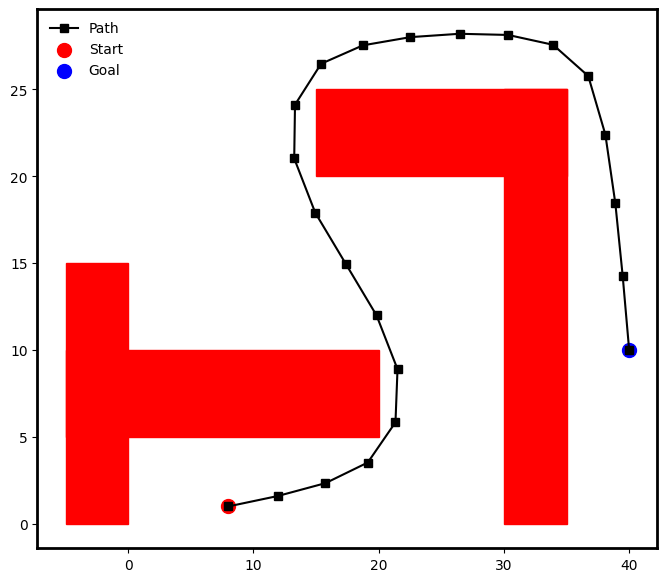

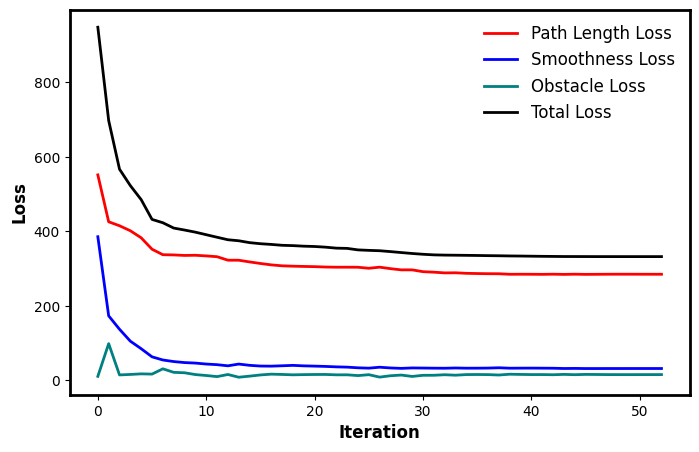

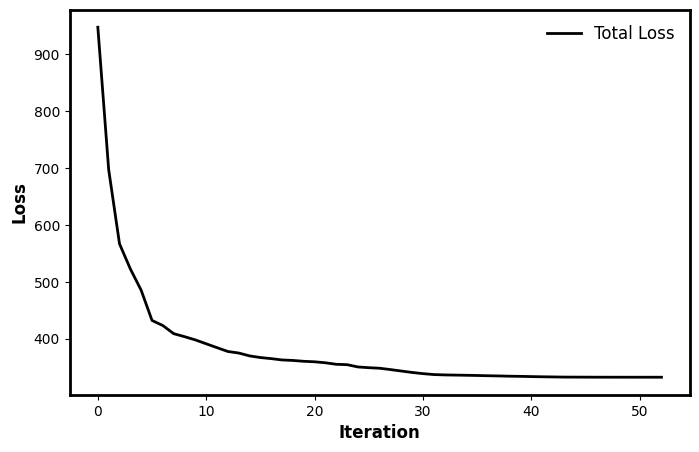

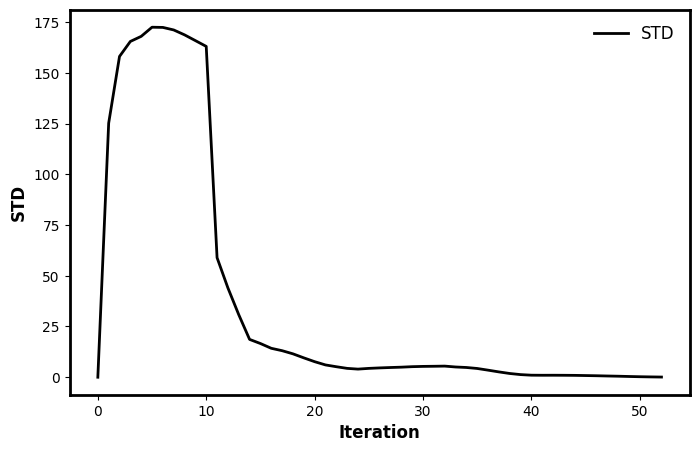

In [9]:

start = np.array([8.0, 1.0], dtype=np.float32)
goal = np.array([40.0, 10.0], dtype=np.float32)


# 이전의 최적화된 경로를 사용
points0 =  x.reshape(N, 2)
x = points0.flatten()
lbfgs = LBFGS(m=8)
history = {"loss": [], "grad_norm": [], "L_length": [], "L_smooth": [], "L_obs": [], "STD": []}
start_time = time.time()
for k in range(max_iters):
    lambda_obs = min([lambda_obs + k_ramp, lambda_obs_max])
    def total_loss_and_grad_dynamic(x_in):
        inner = x_in.reshape(N,2)
        L1,g1 = path_length_Loss(start, goal, inner)
        L2,g2 = path_smoothness_Loss(start, goal, inner)
        L3,g3 = path_obstacle_Loss(start, goal, inner, obstacles, sample_pts_base=sample_pts, margin=margin)
        loss = lambda_length*L1 + lambda_smooth*L2 + lambda_obs*L3
        grad = lambda_length*g1 + lambda_smooth*g2 + lambda_obs*g3
        return loss, grad.flatten(), L1, L2, L3
    f,g,L1,L2,L3 = total_loss_and_grad_dynamic(x)
    grad_norm = np.linalg.norm(g)
   
    history = History_Save(history, f, grad_norm, lambda_length, lambda_smooth, lambda_obs, L1, L2, L3, k)
    
    # terminate condition
    if k > 20 and np.std(history['loss'][-10:-1]) < tol:
        print(f"Gradient norm {grad_norm:.3e} < tol -> stop at iter {k}")
        break
    
    H_g = lbfgs.two_loop(g)
    p = -H_g

    alpha, f_new = line_search(x,f,g,p, lambda x_in: total_loss_and_grad_dynamic(x_in)[:2])
    x_new = x + alpha*p
    f_new, g_new, L1_new, L2_new, L3_new = total_loss_and_grad_dynamic(x_new)[:5]
    s = x_new - x
    y = g_new - g
    if np.dot(s,y) > 1e-10:
        lbfgs.update(s,y)
    x = x_new
    f = f_new
    g = g_new

    #Save_Frame(x, N, start, goal, obstacles,k, frame_dir)

    if k % 50 == 0 or k == max_iters-1:
        print(f"iter {k}: loss={f:.6e}, grad_norm={grad_norm:.3e}")

opt_time = time.time() - start_time
print(f"Optimization time: {opt_time:.3f} s, final loss={f:.2f}")

# ============================== 
# plotting and saving results
Plot_Optimized_Path(x, N, start, goal, obstacles)
Plot_Optimized_All_History(history)
Plot_Optimized_History(history, 'loss', "Loss", "Total Loss")
Plot_Optimized_History(history, "STD", "STD", "STD")

#Save_History2Csv(history, history_dir, history_name)